# Swan Project, Analysis of Churners - Team 7
This notebook covers our exploration and prediction of the churning of customers within the Swan database provided.

## 0. Imports

In [ ]:
# Import statements and set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from matplotlib.colors import to_rgb
from matplotlib.patches import Patch

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

two_palette=['#2c3e6c', '#b0c4de']
three_palette = ['#2c3e6c', '#b0c4de', '#98A8B6']
five_palette = ['#2c3e6c', '#b0c4de', '#98A8B6', '#7F8C8D', '#2A2A2A']

## 1. Exploratory Data Analysis
### 1.1. Initial Checks
We first investigated the dataset to explore whether there was any anomalous data, as well as establishing basic insights into which types of customers are likely to churn and why they would do so.

In [ ]:
df = pd.read_csv("Project_Data.csv")
print("Data Shape:", df.shape)
print("Data Nulls:\n", df.isna().sum())

We initially briefly investigate the nulls located within Churn Reason to establish the reason for this large number of nulls, finding that there are only nulls for 'Churn Reason' when the customer has not churned, which is wholly logical and thus means the data is consistent still with these nulls.

In [ ]:
# this shows that the only null values are for reason when churn value is 0 which is wholly logical.
nullReason = df[df['Churn Reason'].isna()].copy()
nullReason['Churn Value'].value_counts()

### 1.2. Renaming columns

We rename the variables to more standard coding practices.

In [ ]:
# Rename columns for consistency
df = df.rename(columns={
    'CustomerID': 'customer_id',
    'Churn Label': 'churn_flag',
    'Churn Value': 'churn_value',
    'Churn Reason': 'churn_reason',
    'Tenure Months': 'tenure_months',
    'Monthly Charges': 'monthly_charges',
    'Total Charges': 'total_charges'
})

### 1.3. Demographics of churners
We explore different visualisations of relationships between churners and different features within the dataset.
Prior to doing this, we note that we normalise our values within the graph so that we give a percentage of the total number of people who did or didn't churn. This can be seen by the fact that for each set of bars, the percentages add to 100%.

- Gender does not affect churn
- Senior citizens have a higher chance to churn
- Partner & Dependents have a lower chance to churn

In [ ]:
#Demographic Analysis - Cool Visualizations
columns = ['Gender', 'Senior Citizen', 'Partner', 'Dependents']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df[col], df['churn_flag'], normalize='columns') * 100
    # Create bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14)
    axes[idx].set_xlabel(col, fontsize=12)
    # We use percentages so that the data is  scaled appropriately.
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)
    axes[idx].legend(title='Churn Label', loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

These all have the highest churn rate of their respective contractual categories:
- Fiber optic
- Month-month
- Electronic checks

In [ ]:
# Payments and Internet Service Graphs
columns = ['Internet Service', 'Contract', 'Payment Method']
# Service Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df[col], df['churn_flag'], normalize='columns') * 100
    # Create bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14)
    axes[idx].set_xlabel(col, fontsize=12)
    # We use percentages so that the data is  scaled appropriately.
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)
    axes[idx].legend(title='Churn Label', loc='upper right', fontsize=10)

sns.boxplot(data=df, x='churn_flag', y='monthly_charges', ax=axes[3], palette=two_palette, hue = 'churn_flag')
axes[3].set_title('Monthly Charges Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Churn Label')

plt.tight_layout()
plt.show()

Tech add ons such as:
- Online security
- Online backup
- Device protection
- Tech support

All reduce churn rate. TV & Movie streaming services do not reduce churn by a noticeable amount.

In [ ]:
# Columns to analyze
columns = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support','Streaming TV', 'Streaming Movies']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 9))
axes = axes.flatten()

# Remove rows where InternetService is 'No'
df_internet = df[df['Internet Service'] != 'No']

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df_internet[col], df_internet['churn_flag'], normalize='columns') * 100

    # Create bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14)
    axes[idx].set_xlabel(col, fontsize=12)
    # We use percentages so that the data is  scaled appropriately.
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)
    axes[idx].legend(title='Churn Label', loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

Neither Phone service nor Multiple lines seem to affect churn by a reasonable amount

In [ ]:
# Columns to analyze
columns = ['Phone Service', 'Multiple Lines']

# Create subplots
fig, axes = plt.subplots(1, len(columns), figsize=(14, 6))

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df[col], df['churn_flag'], normalize='columns') * 100

    # Create horizontal bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14)
    axes[idx].set_xlabel(col, fontsize=12)
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)

plt.tight_layout()
plt.show()

Churn is vastly affected by tenure  
Customers that stay with the company for longer than a month sharply increase their retention rate [add value here]

In [ ]:
# Tenure Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Tenure distribution by Churn
sns.histplot(data=df, x='tenure_months', hue='churn_flag', bins=30, ax=axes[0], palette=two_palette, alpha = 1)
axes[0].set_title('Tenure Distribution by Churn Status', fontsize=14, fontweight='bold')

# Churn rate by tenure groups
df['Tenure Group'] = pd.cut(df['tenure_months'], bins=[0, 12, 24, 36, 48, 72, 100],
                           labels=['0-12', '13-24', '25-36', '37-48', '49-72', '73+'])
tenure_churn = pd.crosstab(df['Tenure Group'], df['churn_flag'], normalize='index') * 100
tenure_churn.plot(kind='bar', ax=axes[1], color=two_palette)
axes[1].set_title('Churn Rate by Tenure Groups', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Percentage (%)')

plt.tight_layout()
plt.show()

### 1.3. Churn Drivers
We investigated what led to customers churning.  
The top reasons were due to Poor Customer Support and Competetors having higher download speed/more data

[LOOK INTO FIBER OPTIC/DSL SPLIT OF COMPETETOR REASONS?]

In [ ]:
# Graphing the top reasons customers gave for churning
# Convert hex to RGB tuples


start_rgb = to_rgb(five_palette[1])
end_rgb = to_rgb(five_palette[0])

# Create a custom palette by interpolating between the two
n_colors = 18  # Number of colors in the palette
palette = [
    (
        start_rgb[0] + (end_rgb[0] - start_rgb[0]) * i / (n_colors - 1),
        start_rgb[1] + (end_rgb[1] - start_rgb[1]) * i / (n_colors - 1),
        start_rgb[2] + (end_rgb[2] - start_rgb[2]) * i / (n_colors - 1)
    )
    for i in range(n_colors)
]
churnValue_Reason = df[['churn_value', 'churn_reason']]
churnValue_Reason
churned = churnValue_Reason[churnValue_Reason['churn_value'] == 1]
reasonCounts = churned.value_counts()
reasonCounts = pd.DataFrame(reasonCounts).reset_index().rename(columns={'index': 'churn_reason', 0: 'Count'})
reasonCounts
plt.figure(figsize=(12,6))
sns.barplot(x=reasonCounts['churn_reason'], y=reasonCounts['count'], palette=palette, hue = reasonCounts['count'])
plt.xlabel('Churn Reason')
plt.xticks(rotation= 45, # rotating labels
           horizontalalignment = 'right', # aligning them with the bars
           fontweight = 'light',
           fontsize = 'large' # setting the fonts
          )
plt.ylabel('No. Of Customers')
plt.title('Customer Churn Reasons')
# Create custom legend with first and last colors
legend_elements = [
    Patch(facecolor=palette[-1], label='Highest Churn'),
    Patch(facecolor=palette[0], label='Lowest Churn')
]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1), frameon=False)
plt.show()

In [ ]:
# Creating correlation to see what factors have a negative correlation with churn value.
plt.figure(figsize = (15,15))
sns.heatmap(data = df.corr(numeric_only = True),
            cmap = palette, 
            annot = True)
plt.show()

## 2. Modelling Churn Risk
We begin by creating a basic model from which we can begin to assess the potential risk of customers churning.

Make logistic regression & random forest  
Select best on accuracy & f1 score  
Find top 500 list & complete customer churn % chance  

In [23]:
# Feature engineering function, maps binary columns to integers (0 and 1)
def feature_engineering(df):
    df_local = df.copy()

    # Convert gender to numeric
    df_local['Gender'] = df_local['Gender'].map({'Male': 0, 'Female': 1})

    # Binary yes/no features
    fe_list = ['Senior Citizen', 'Partner', 'Dependents',
               'Phone Service', 'Paperless Billing']
    for feature in fe_list:
        if feature in df_local.columns:
            df_local[feature] = df_local[feature].map({'No': 0, 'Yes': 1})

    # Internet-related categorical features (one-hot encode)
    internet_list = [
        'Online Security', 'Online Backup', 'Device Protection',
        'Tech Support', 'Streaming TV', 'Streaming Movies', 'Internet Service',
        'Contract', 'Payment Method'
    ]
    df_local = pd.get_dummies(
        data=df_local,
        columns=internet_list,
        drop_first=True,
        dtype='int'
    )

    # Multiple Lines mapping
    if 'Multiple Lines' in df_local.columns:
        df_local['Multiple Lines'] = df_local['Multiple Lines'].map({
            'No': 0,
            'Yes': 1,
            'No phone service': 0
        })

    return df_local

df_eng = feature_engineering(df)

In [24]:
# Features and target
drop_cols = [
    'Country',
    'State',
    'City',
    'Zip Code',
    'Lat Long',
    'Latitude',
    'Longitude',
    'customer_id',
    'churn_flag',
    'churn_value',
    'churn_reason',
    'Internet Service',
    'Contract',
    'Tenure Group'
    ]

X = df_eng.drop(columns=drop_cols, errors='ignore')

y = df_eng['churn_flag']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
### Fill missing values
median = X_train.loc[~(X_train['total_charges'] == ' ')]['total_charges'].astype('float').median()
print(f'The median value of total charges is {median}')
X_train['total_charges'] = X_train['total_charges'].replace({' ': median})
X_test['total_charges'] = X_test['total_charges'].replace({' ': median})

The median value of total charges is 1388.0


In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Classification Report:
               precision    recall  f1-score   support

          No       0.83      0.90      0.86      1009
         Yes       0.68      0.52      0.59       400

    accuracy                           0.80      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409

ROC AUC: 0.8401350346878097


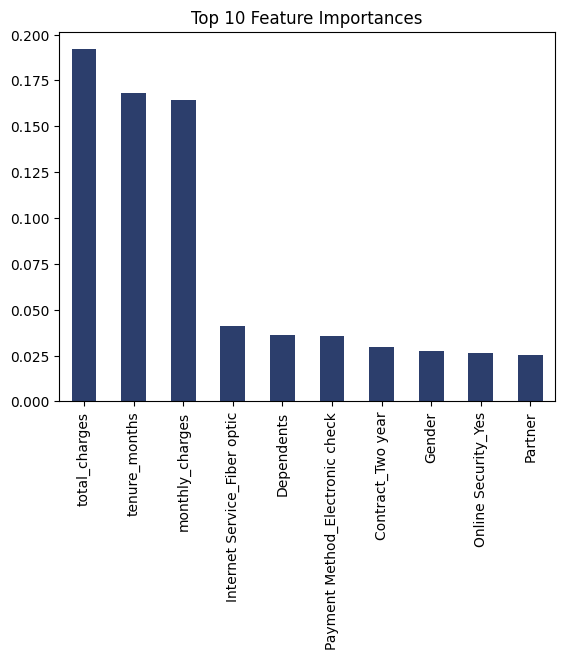

In [27]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances[:10].plot(kind='bar', color='#2c3e6c')
plt.title("Top 10 Feature Importances")
plt.show()

In [29]:
# Logistic Regression

log_reg = LogisticRegression()

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2', 'none'],
}

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

y_pred_log = grid_search.predict(X_test)

y_prob_log = grid_search.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, y_prob_log))



/home/jacob/Digital_Futures/Projects/project_5_swan/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jacob/Digital_Futures/Projects/project_5_swan/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as

Best parameters: {'C': 1, 'penalty': 'l2'}

Classification Report:
               precision    recall  f1-score   support

          No       0.83      0.90      0.86      1009
         Yes       0.68      0.55      0.60       400

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

ROC AUC: 0.8504051040634293


/home/jacob/Digital_Futures/Projects/project_5_swan/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
